In [1]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, wilcoxon, shapiro
from sklearn.model_selection import GridSearchCV
import gc
import itertools
from sklearn.utils import resample
import ast
import json
import re
import statsmodels.api as sm

import utils 
import model_train
from constants import *
import particle_swarm
from scipy.stats import ttest_rel, shapiro, wilcoxon

%load_ext autoreload
%autoreload 2

In [2]:
# Set your folder path
folder_path = '/Users/yusiwei/Library/CloudStorage/OneDrive-Personal/research/Fourth Year Paper/Experiments/2nd experiments/Experiment results/V2/V2_1_G_Mean/Tracking info/'

# Get all files (not directories) in the folder
all_files = [
    f for f in os.listdir(folder_path)
    if os.path.isfile(os.path.join(folder_path, f)) and f != '.DS_Store'
]

# Define a regex pattern to extract k, n_cluster, and model name
pattern = r'track_info_k(\d+)_ncluster(\d+)_([A-Za-z]+)_round(\d+)\.csv?'


In [3]:
Plots_folder = '/Users/yusiwei/Library/CloudStorage/OneDrive-Personal/research/Fourth Year Paper/Experiments/2nd experiments/Experiment results/V2/V2_1_G_Mean/Results'

<h1>Iterations Checking<h1>

In [ ]:
filedirectory = os.path.join(Plots_folder, 'Iterations results')
os.makedirs(filedirectory, exist_ok=True)  # Make sure the folder exists

for file in all_files:
    info = utils.extract_info_from_filename(file, pattern)
    print(f"k: {info['k']}, n_cluster: {info['n_cluster']}, ML model: {info['model']}, Round: {info['round']}")

    # Load the CSV file
    file_path = os.path.join(folder_path, file)
    results_df = pd.read_csv(file_path)

    # Create plot filenames
    base_filename = f"k{info['k']}_ncluster{info['n_cluster']}_{info['model']}"
    loss_plot_path = os.path.join(filedirectory, f"{base_filename}_global_best_max_loss_through_iterations.png")
    combined_plot_path = os.path.join(filedirectory, f"{base_filename}_violations_before_and_after_adjusting_through_iterations.png")

    # Save plots
    utils.plot_global_best_so_far(
        results_df, 'Entropy-Loss', 'Minimum Loss Function Value',
        agg_func='mean', y_range=None, output_path=loss_plot_path,show_plot=True
    )

    utils.plot_global_best_so_far_combined(
        results_df, 
        'total_num_violated_records_before_adjusting', 'Before adjusting',
        'total_num_violated_records_after_adjusting', 'After adjusting', 
        agg_func=None, y_range=None, 
        color_1='red', color_2='blue', output_path=combined_plot_path,show_plot=True
    )

<h1>Comparison Checking -- Maximum Loss<h1>

In [ ]:
metric_column = 'Entropy-Loss'

summary_df = utils.summarize_global_best_across_files(folder_path, pattern, metric_column)
print(summary_df)

In [ ]:
baseline_max_loss_dict = {
    'DT': 14.0570,
    'LR': 0.5762,
    'NB': 2.2771,
    'NN': 3.4248,
    'RF': 0.6991,
    'SVM': 0.6920
}

In [ ]:
filedirectory = os.path.join(Plots_folder, 'Compared to baseline')
os.makedirs(filedirectory, exist_ok=True)  # Make sure the folder exists

utils.plot_model_performance(summary_df, baseline_max_loss_dict, output_path=filedirectory,show_plot=True)

<h1>Comparison Checking -- Average Loss<h1>

In [4]:
baseline_avg_loss_dict = {
    'DT': 11.2059,
    'LR': 0.4975,
    'NB': 1.3150,
    'NN': 7.1022,
    'RF': 0.4919,
    'SVM': 0.6318
}

In [5]:
metric_column = 'Entropy-Loss'

summary_df = utils.summarize_global_best_across_files(folder_path, pattern, metric_column, agg_func='mean')
print(summary_df)

# Save the summary DataFrame to a CSV file
summary_file_path = os.path.join(Plots_folder, 'global_best_loss_each_round_summary.csv')
summary_df.to_csv(summary_file_path, index=False)

   round   k model  global_best  n_cluster  n_clusters_set
0      4  20    DT    10.959073         24              25
1      0  20    DT    10.868964         33              35
2      8  20    DT    10.858151         47              50
3      3  20    DT    10.814898         43              45
4      2  20    DT    10.850942         40              45
..   ...  ..   ...          ...        ...             ...
85     5  20    DT    10.796876         45              50
86     6  20    DT    10.886986         19              20
87     1  20    DT    10.886986         37              40
88     2  20    DT    10.903205         28              30
89     9  20    DT    10.838327         25              25

[90 rows x 6 columns]


In [6]:
new_plot_path = os.path.join(Plots_folder, 'Global best results')

Round: 4
Plotting for model: DT


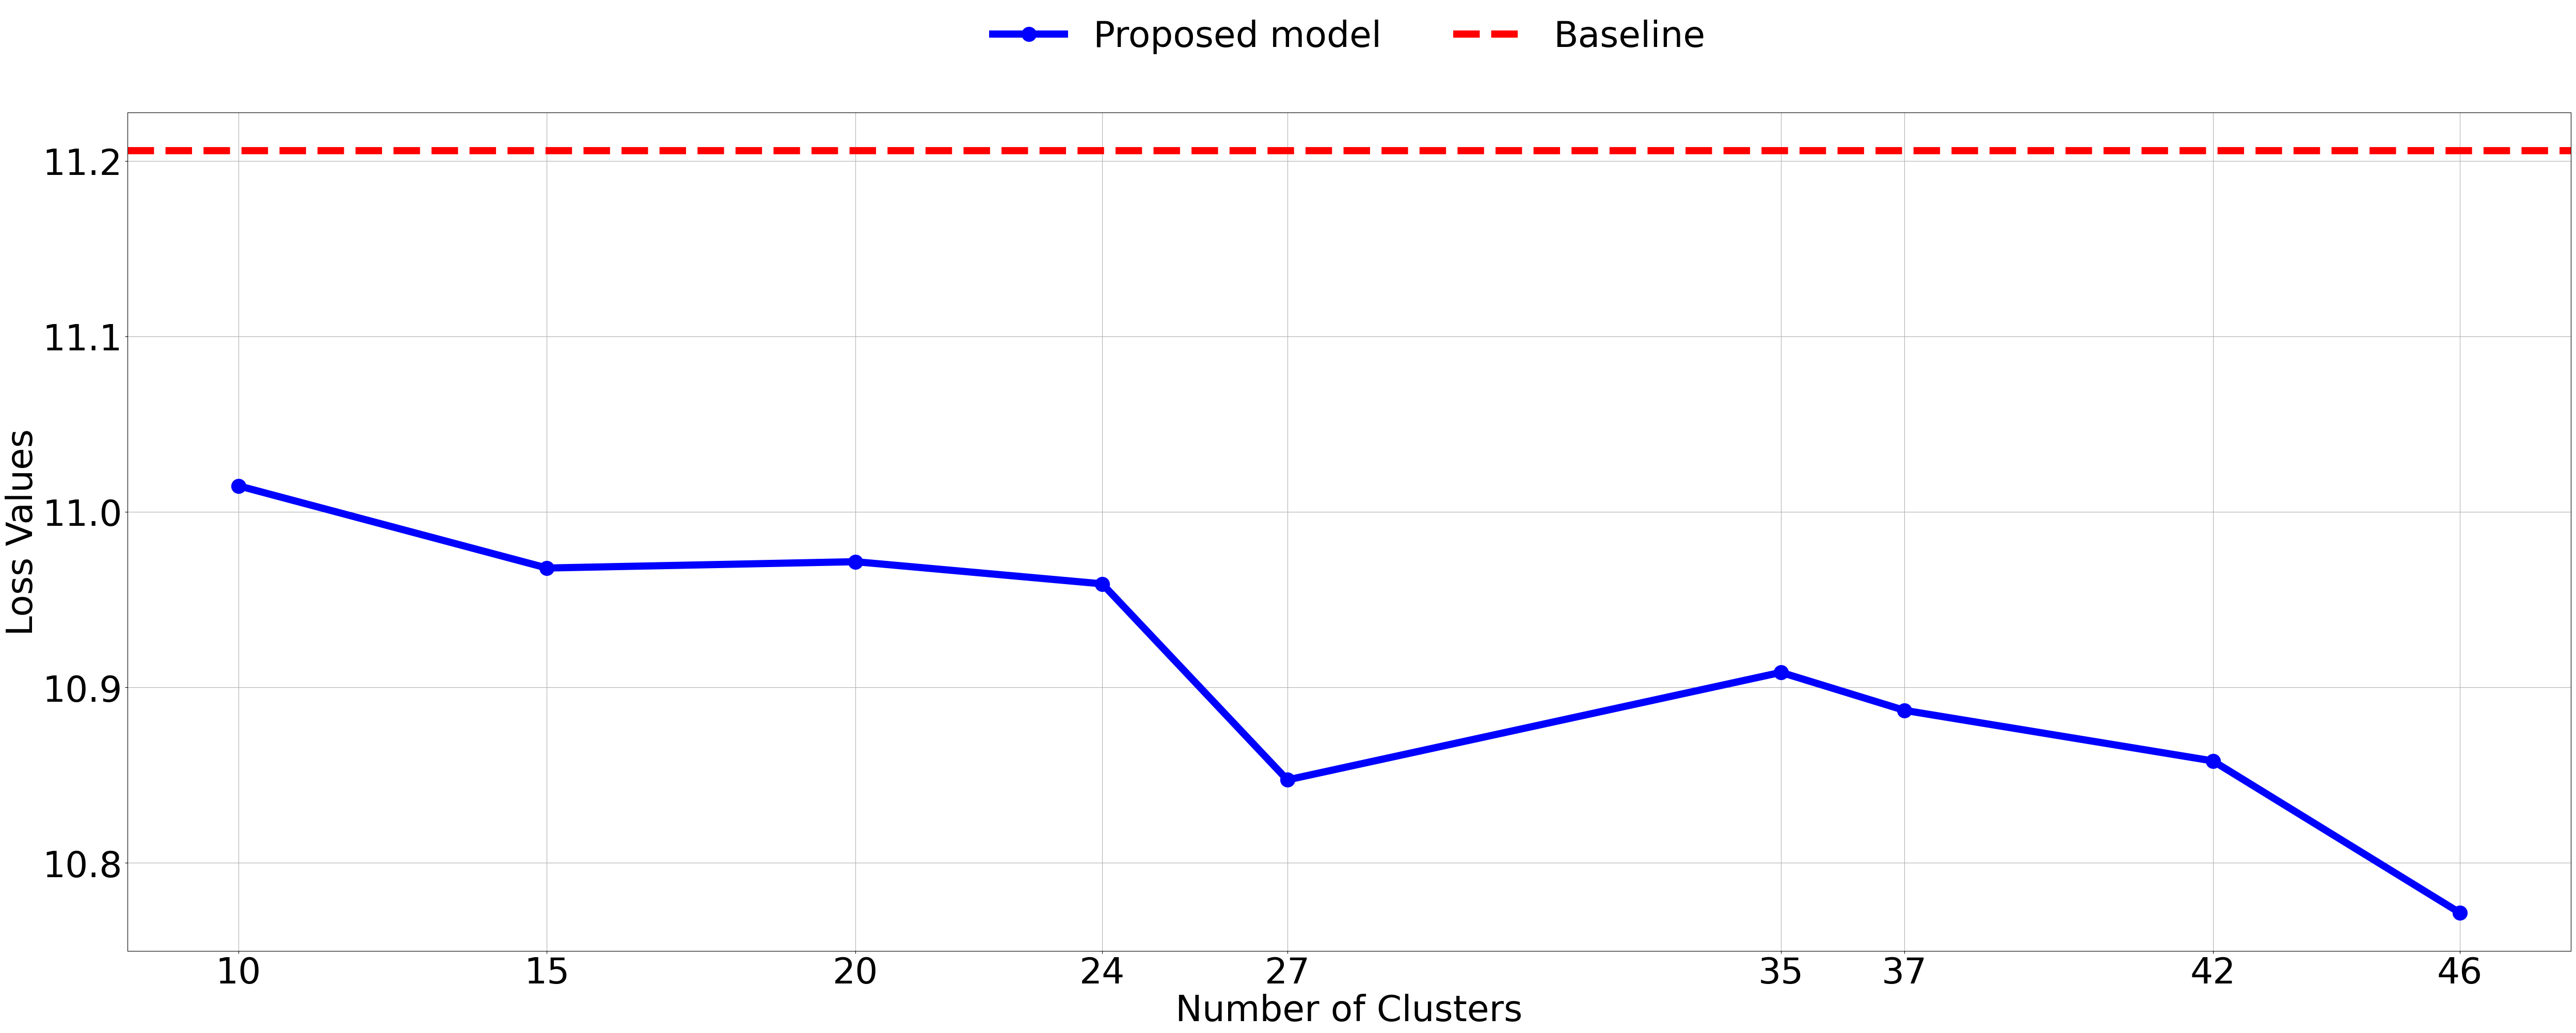

Round: 0
Plotting for model: DT


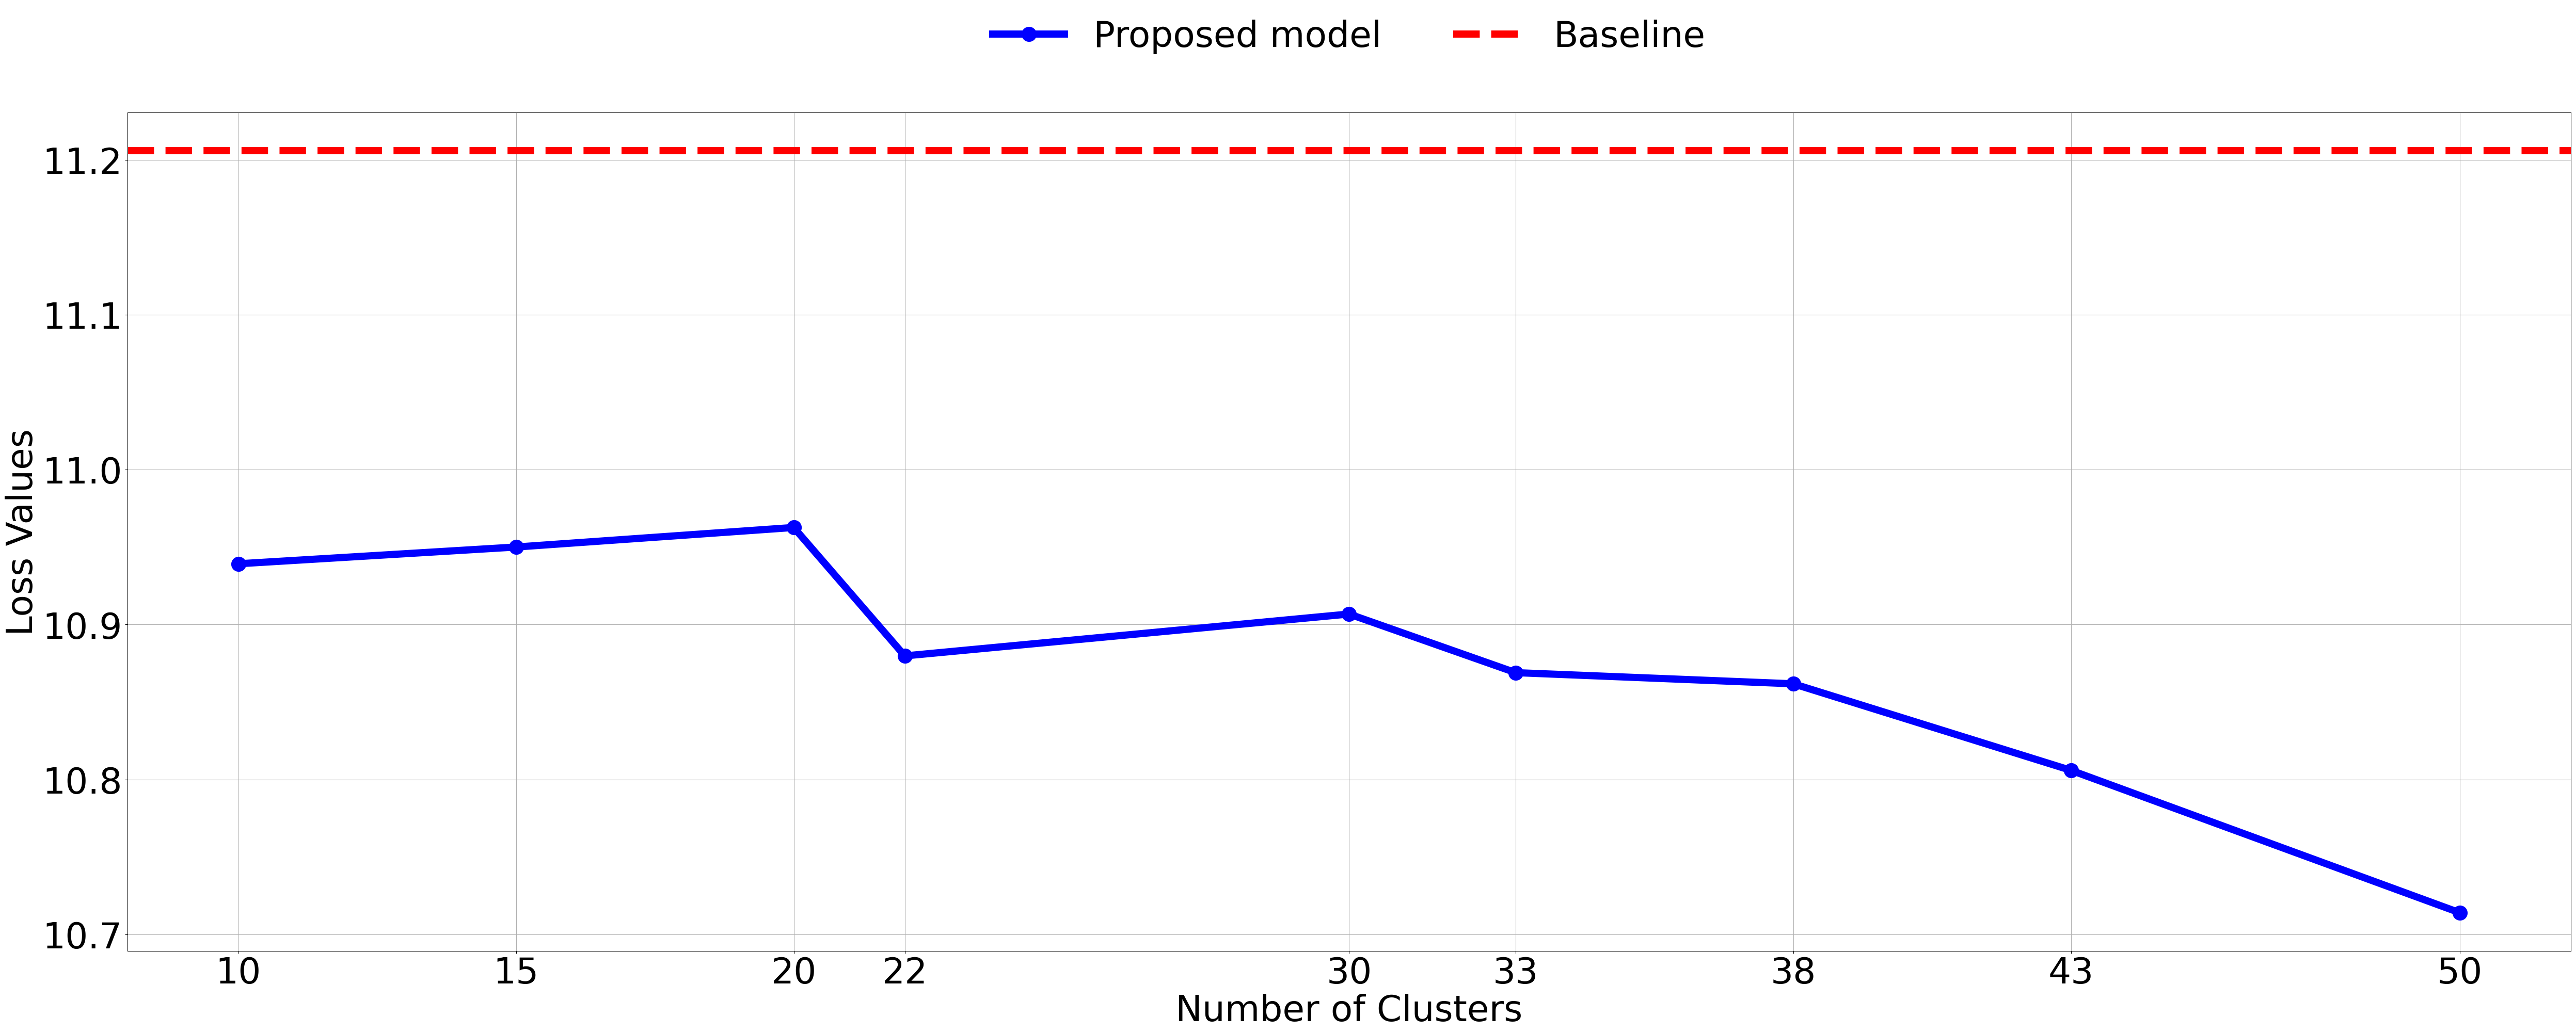

Round: 8
Plotting for model: DT


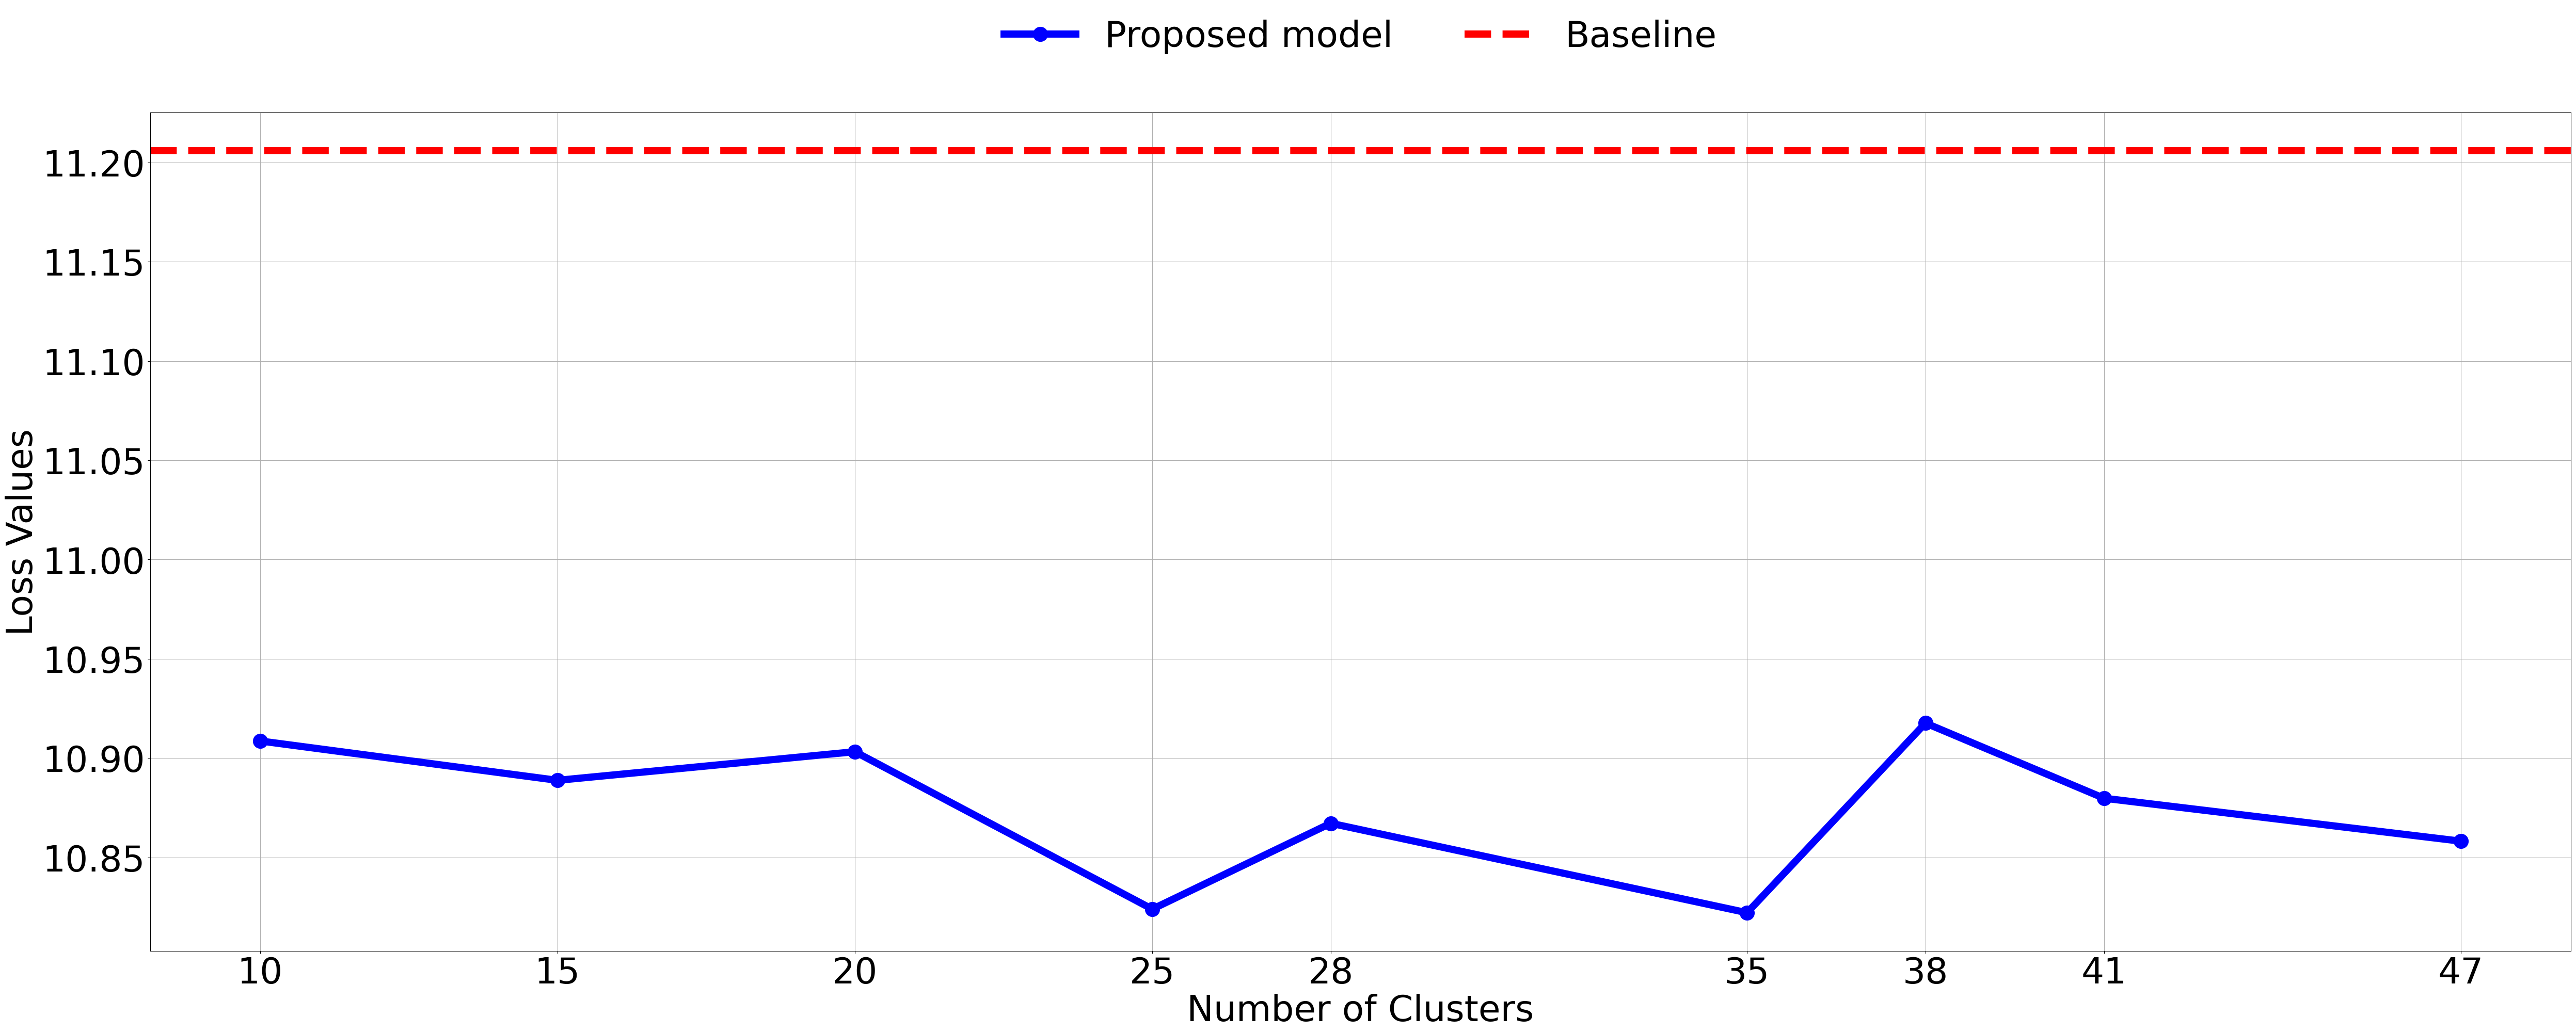

Round: 3
Plotting for model: DT


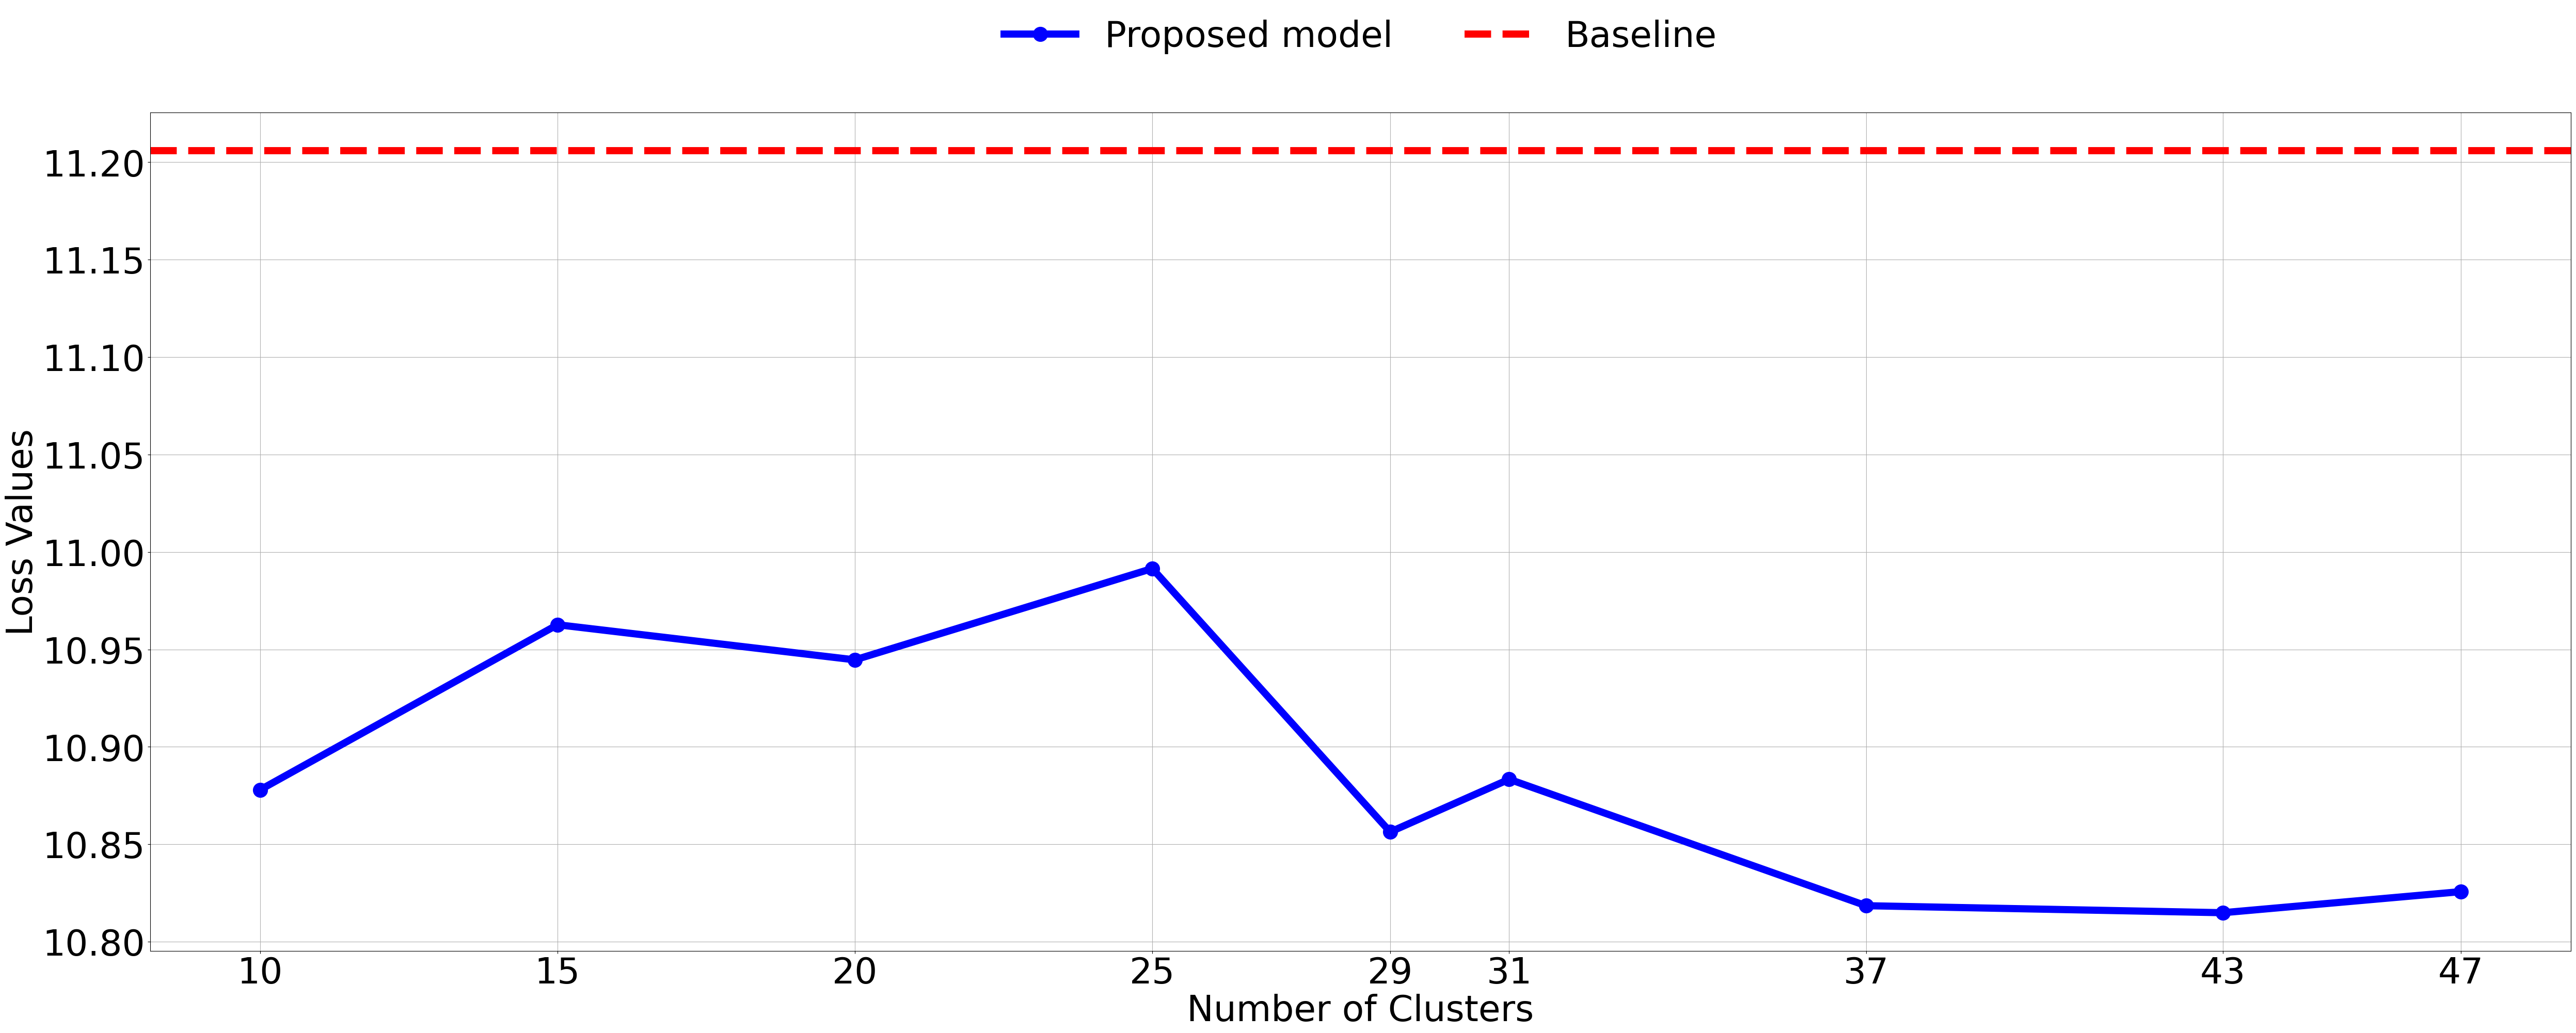

Round: 2
Plotting for model: DT


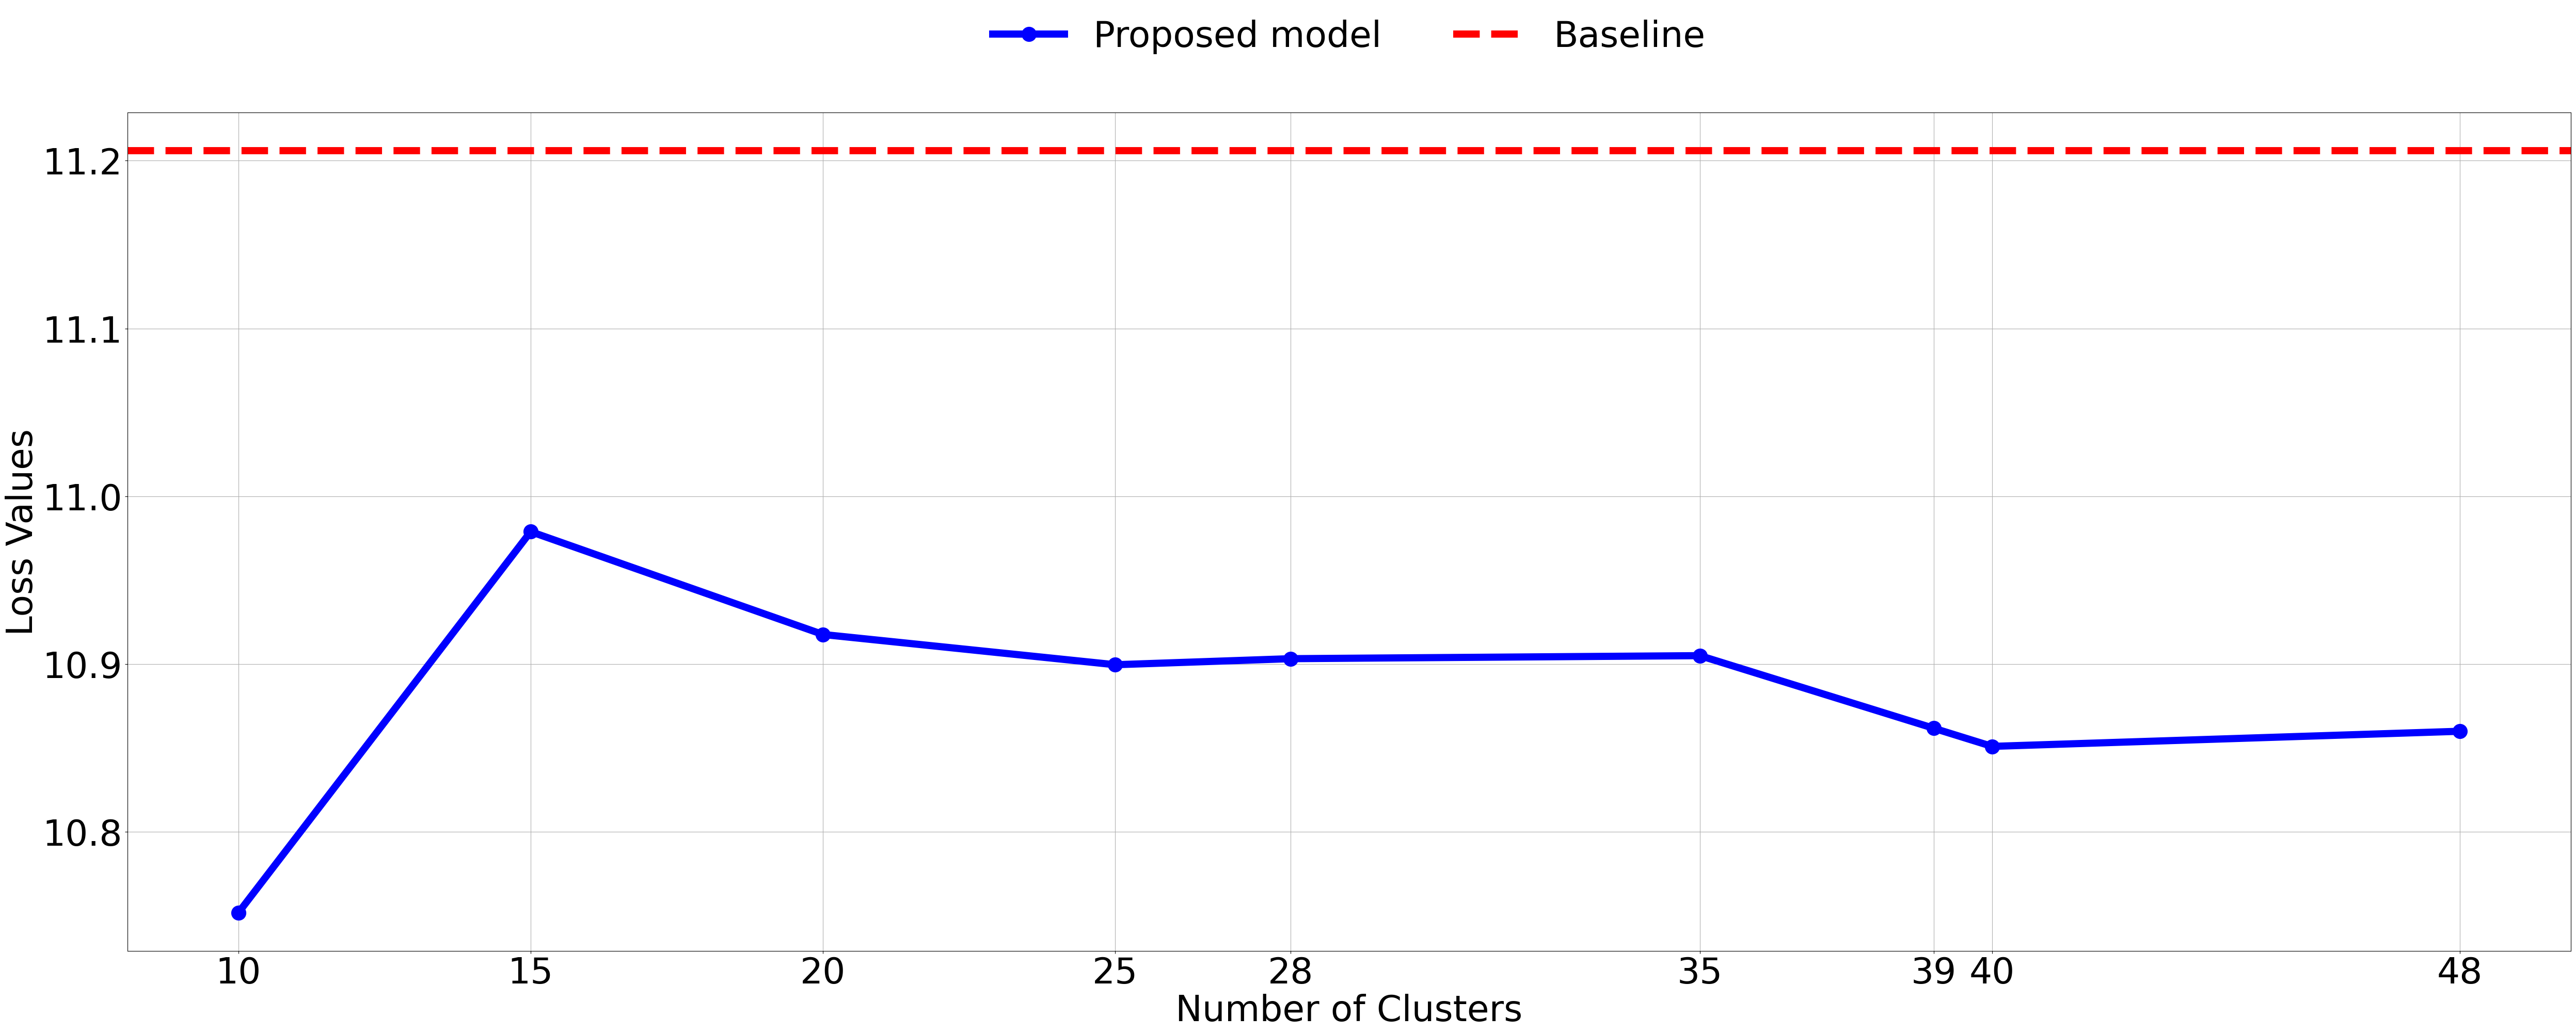

Round: 9
Plotting for model: DT


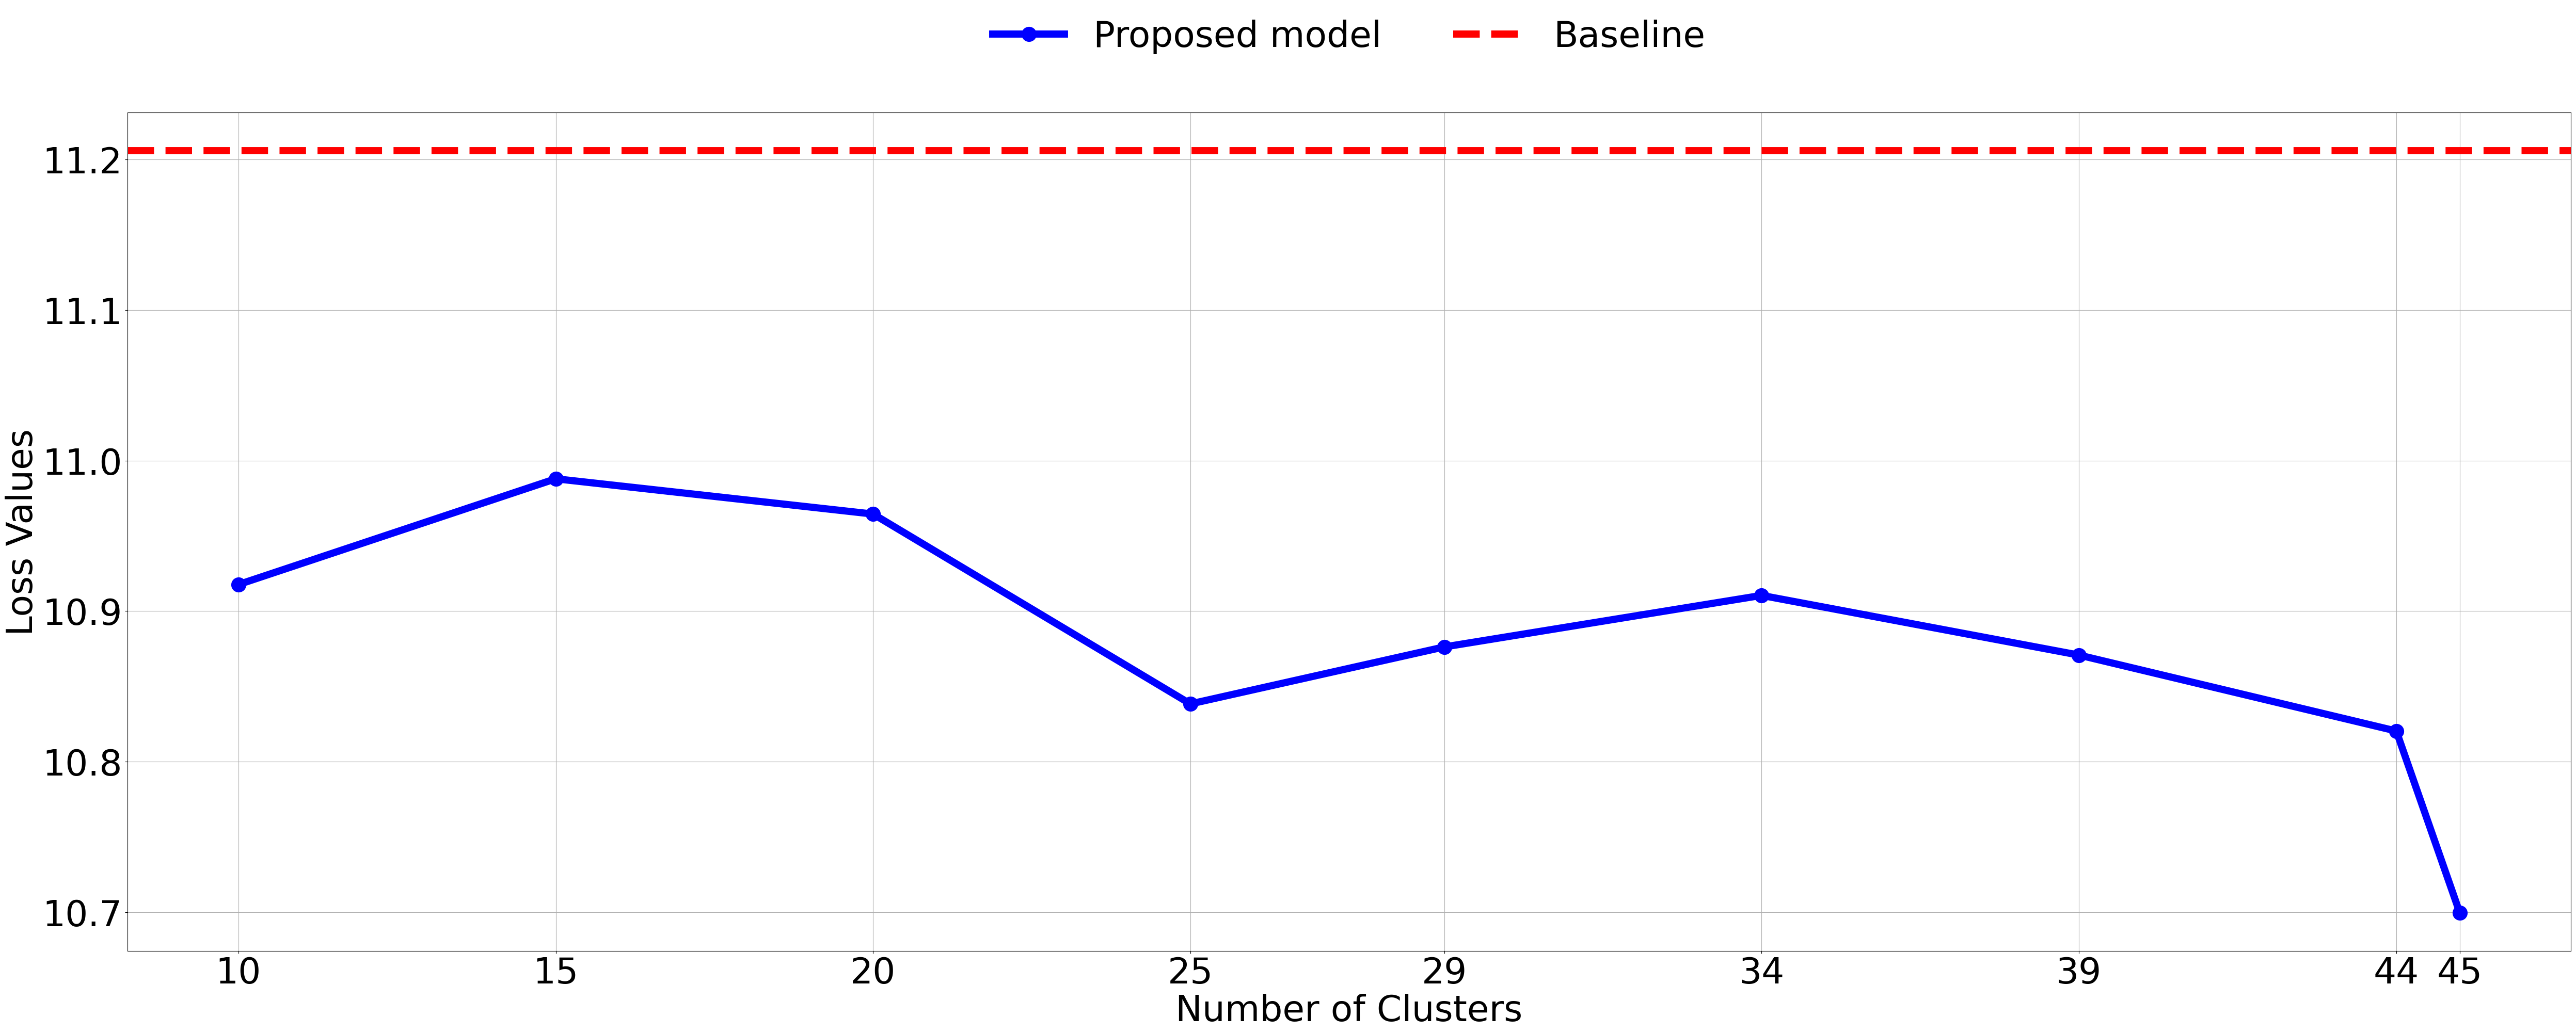

Round: 1
Plotting for model: DT


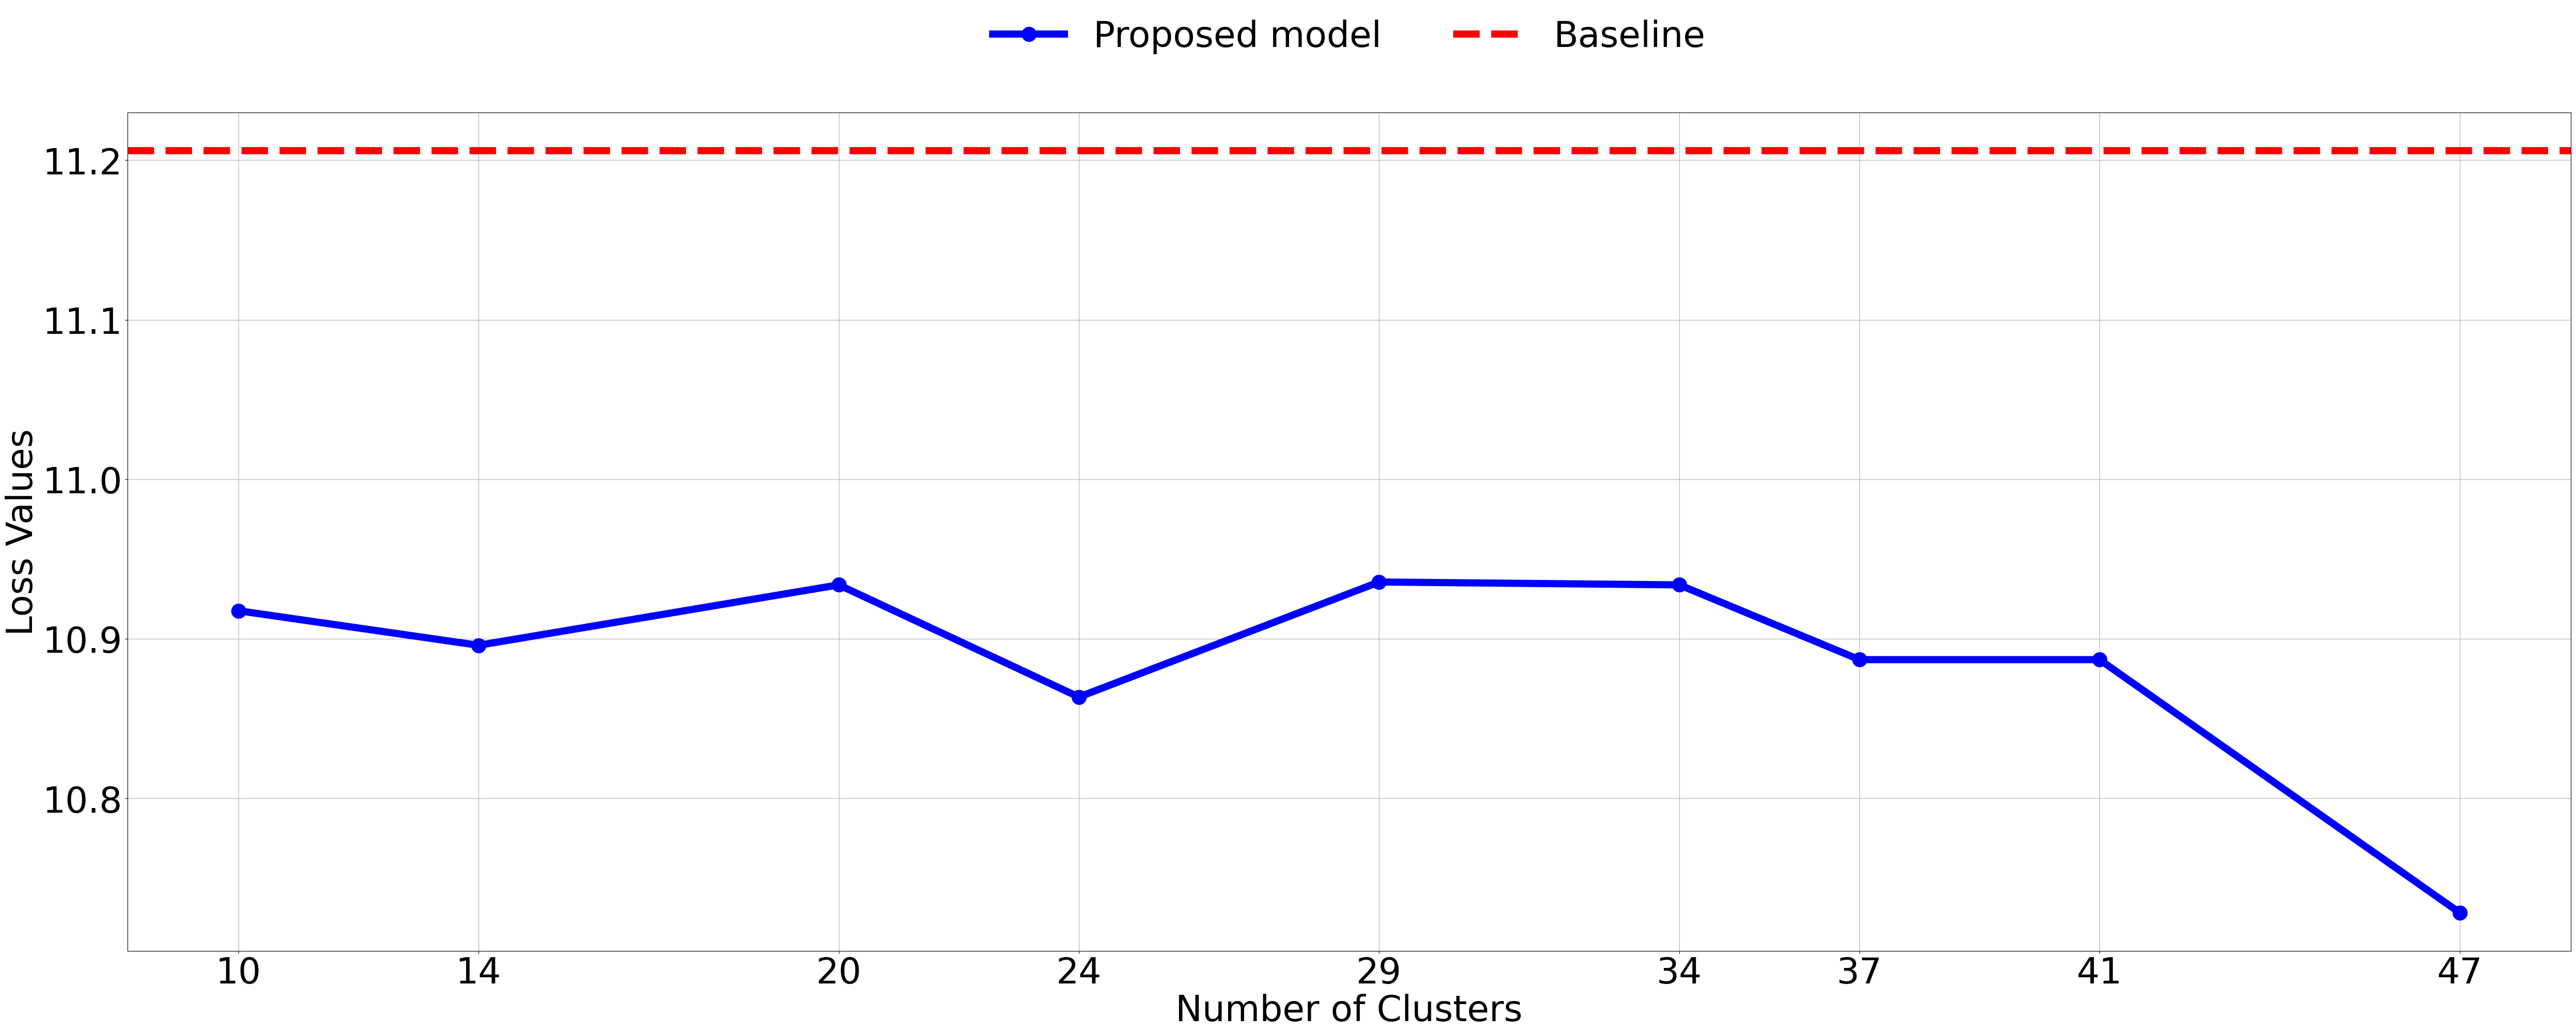

Round: 5
Plotting for model: DT


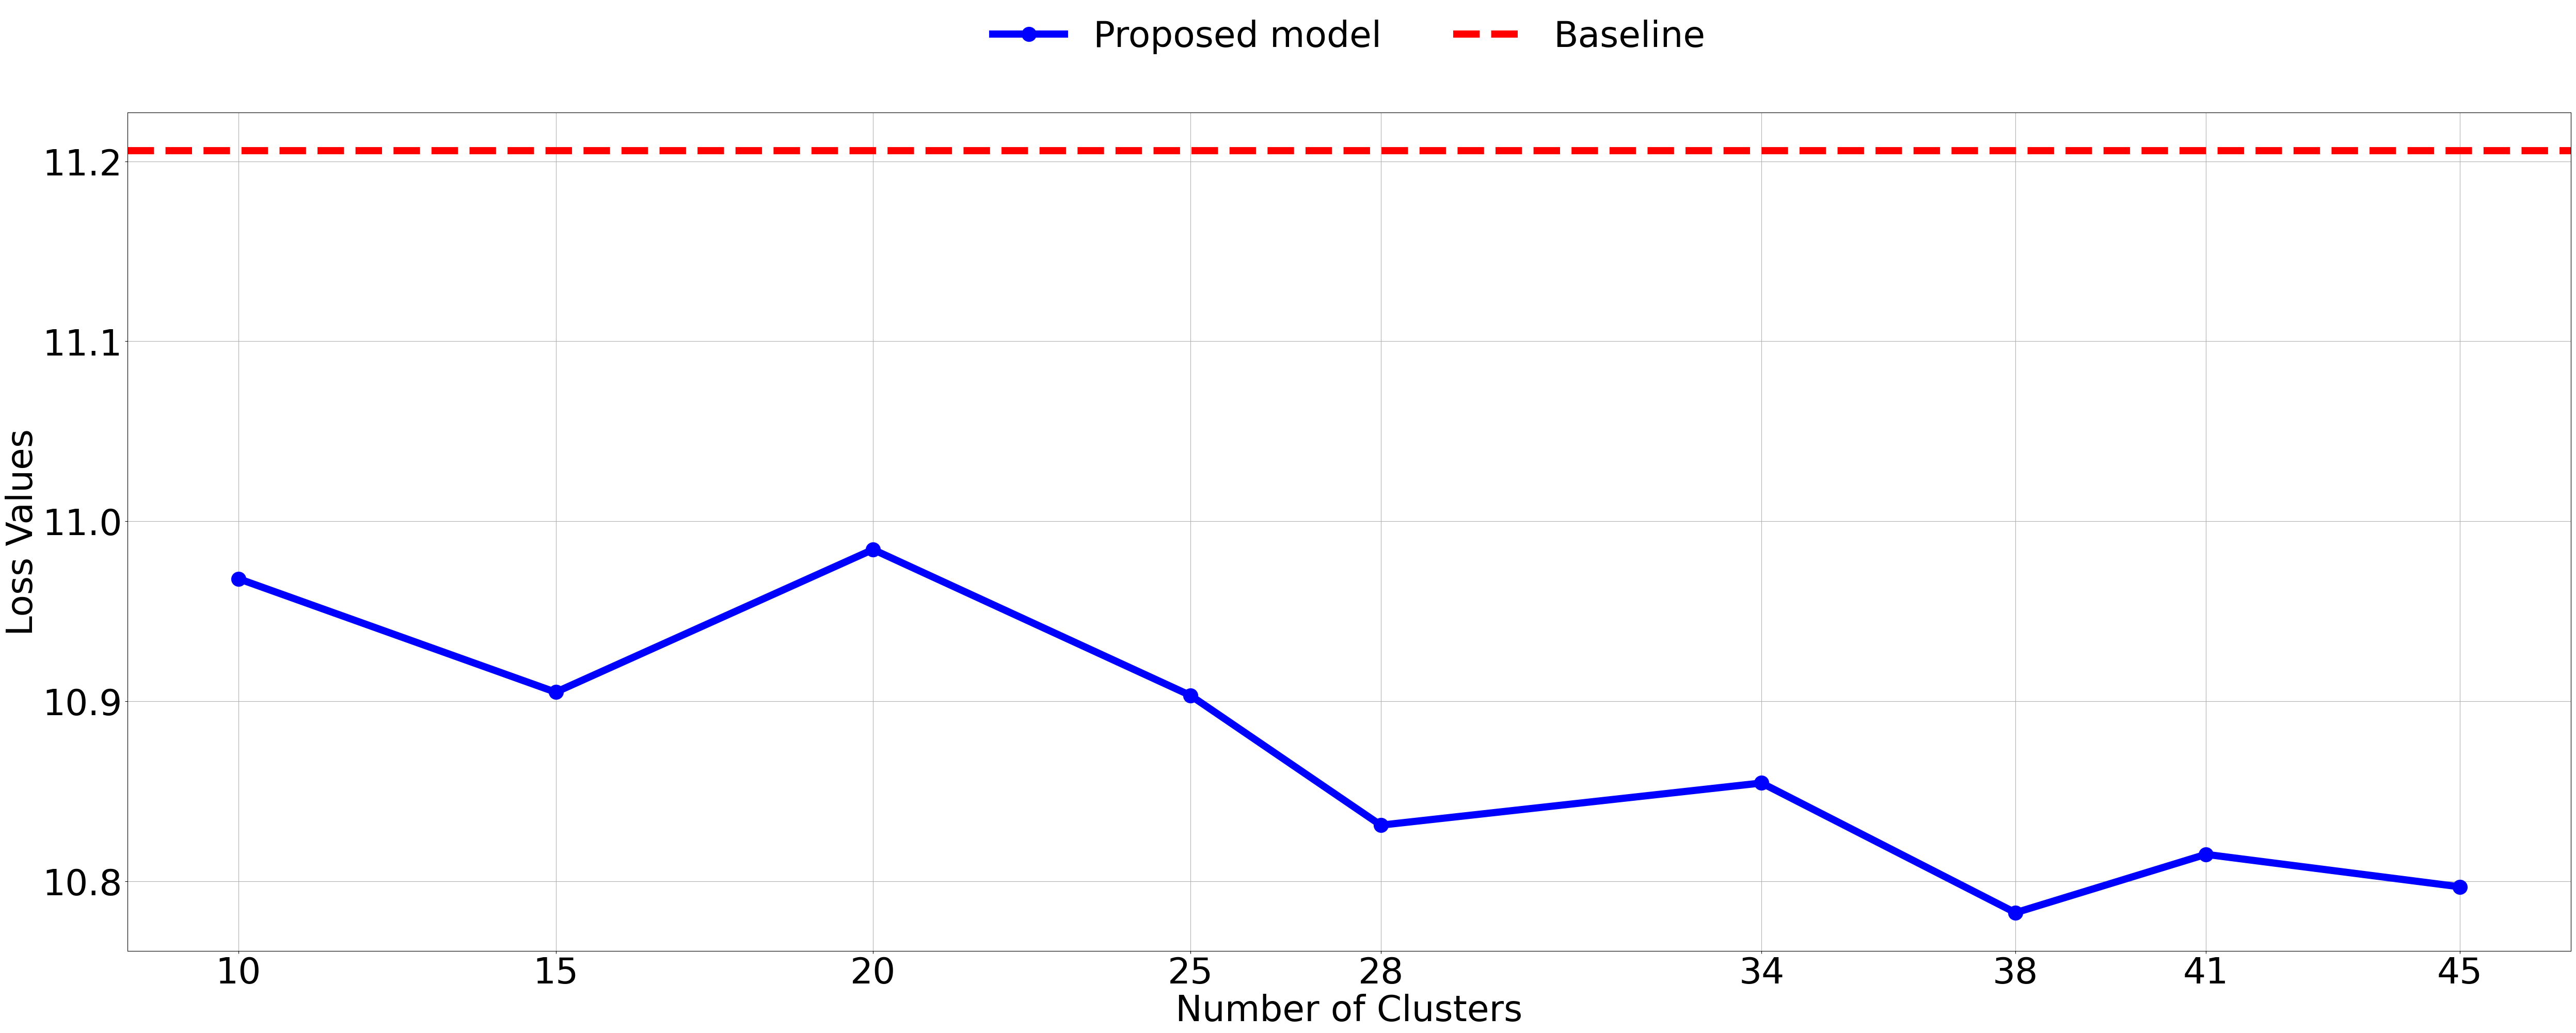

Round: 7
Plotting for model: DT


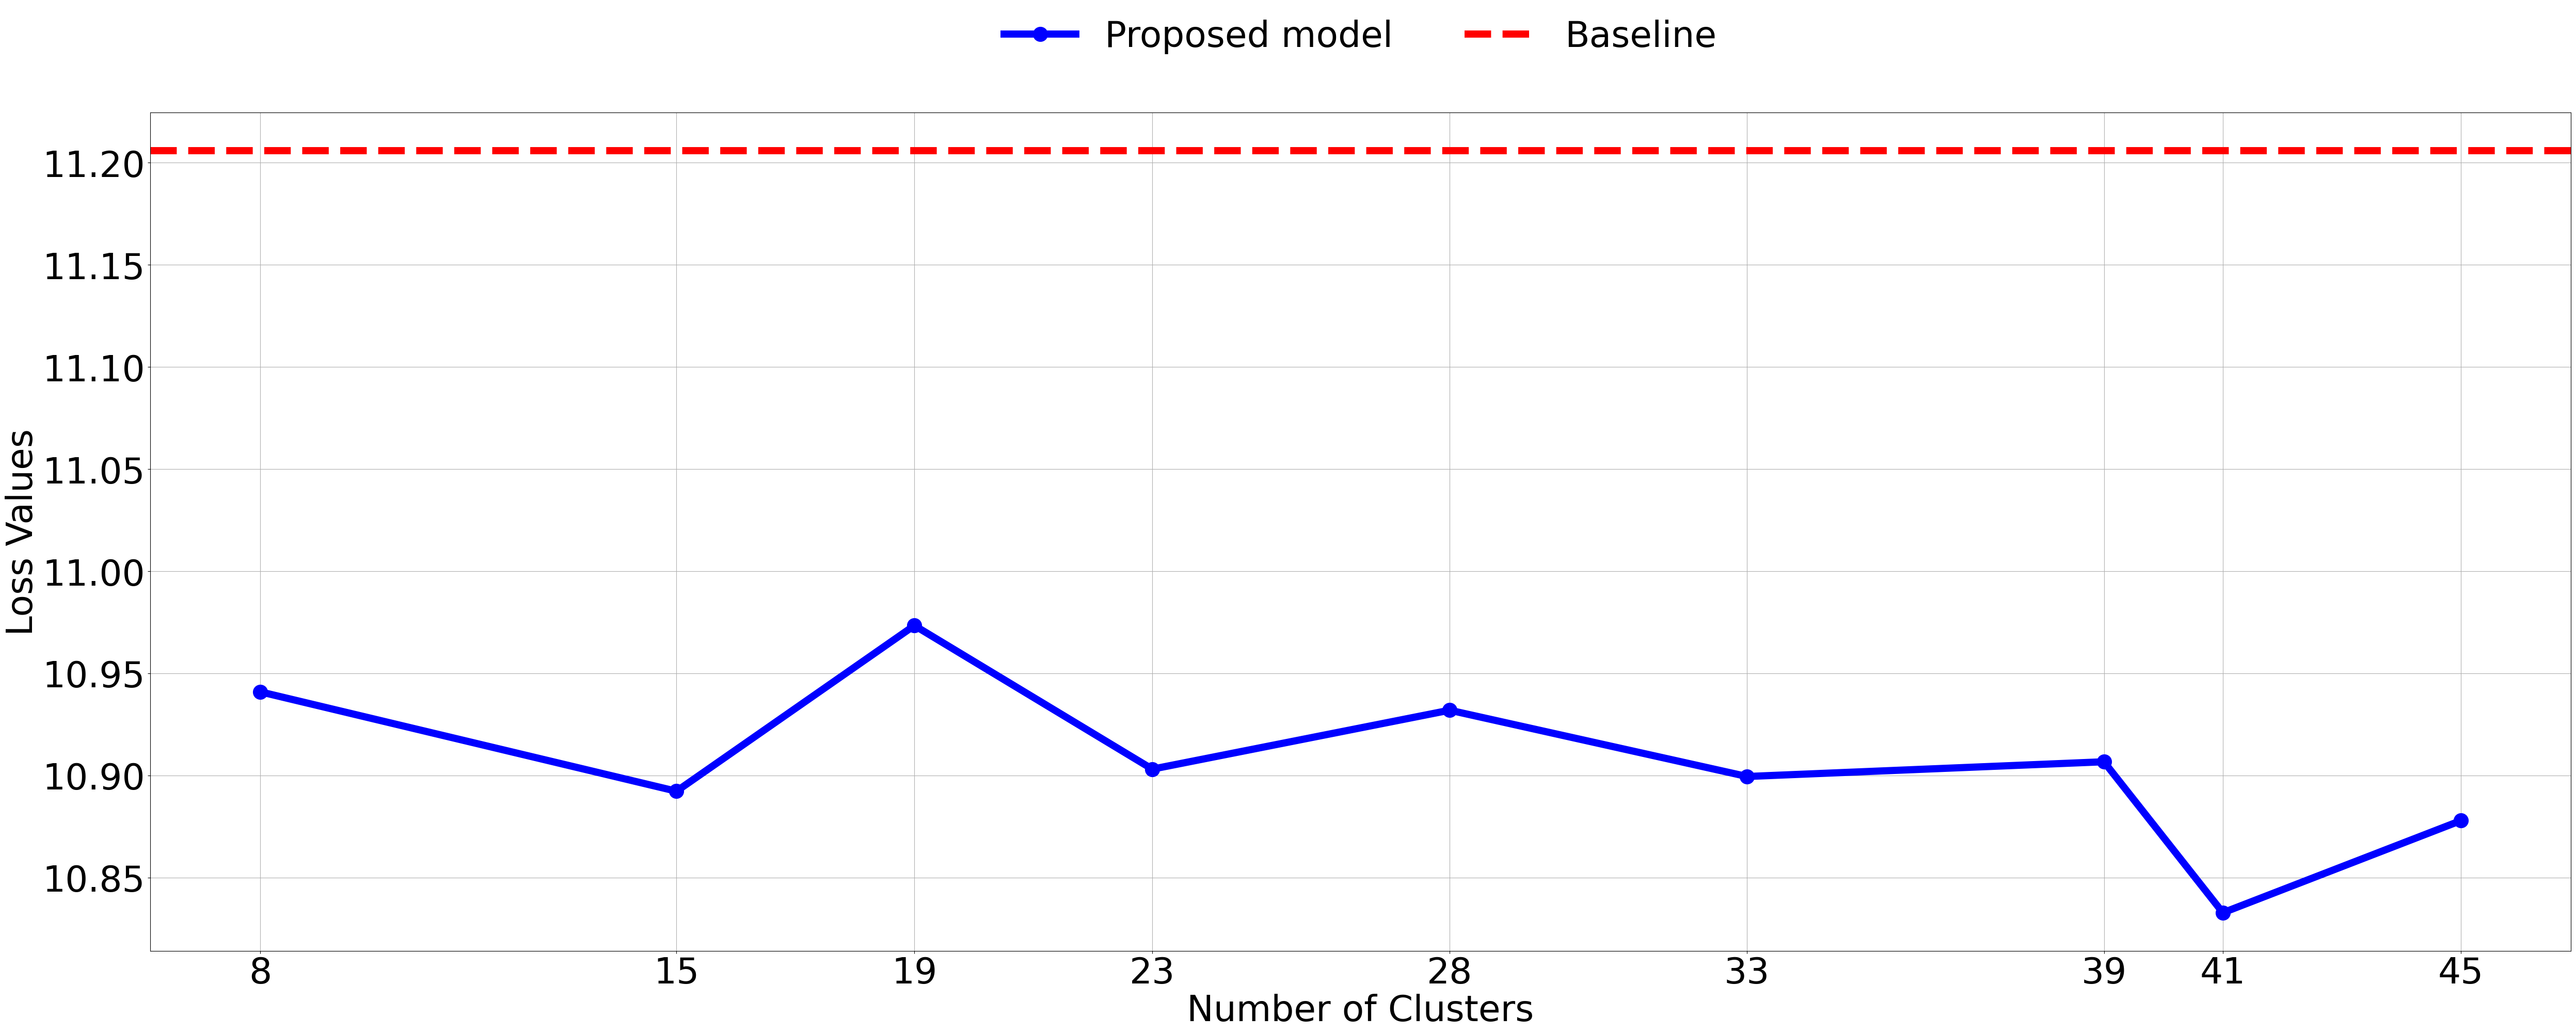

Round: 6
Plotting for model: DT


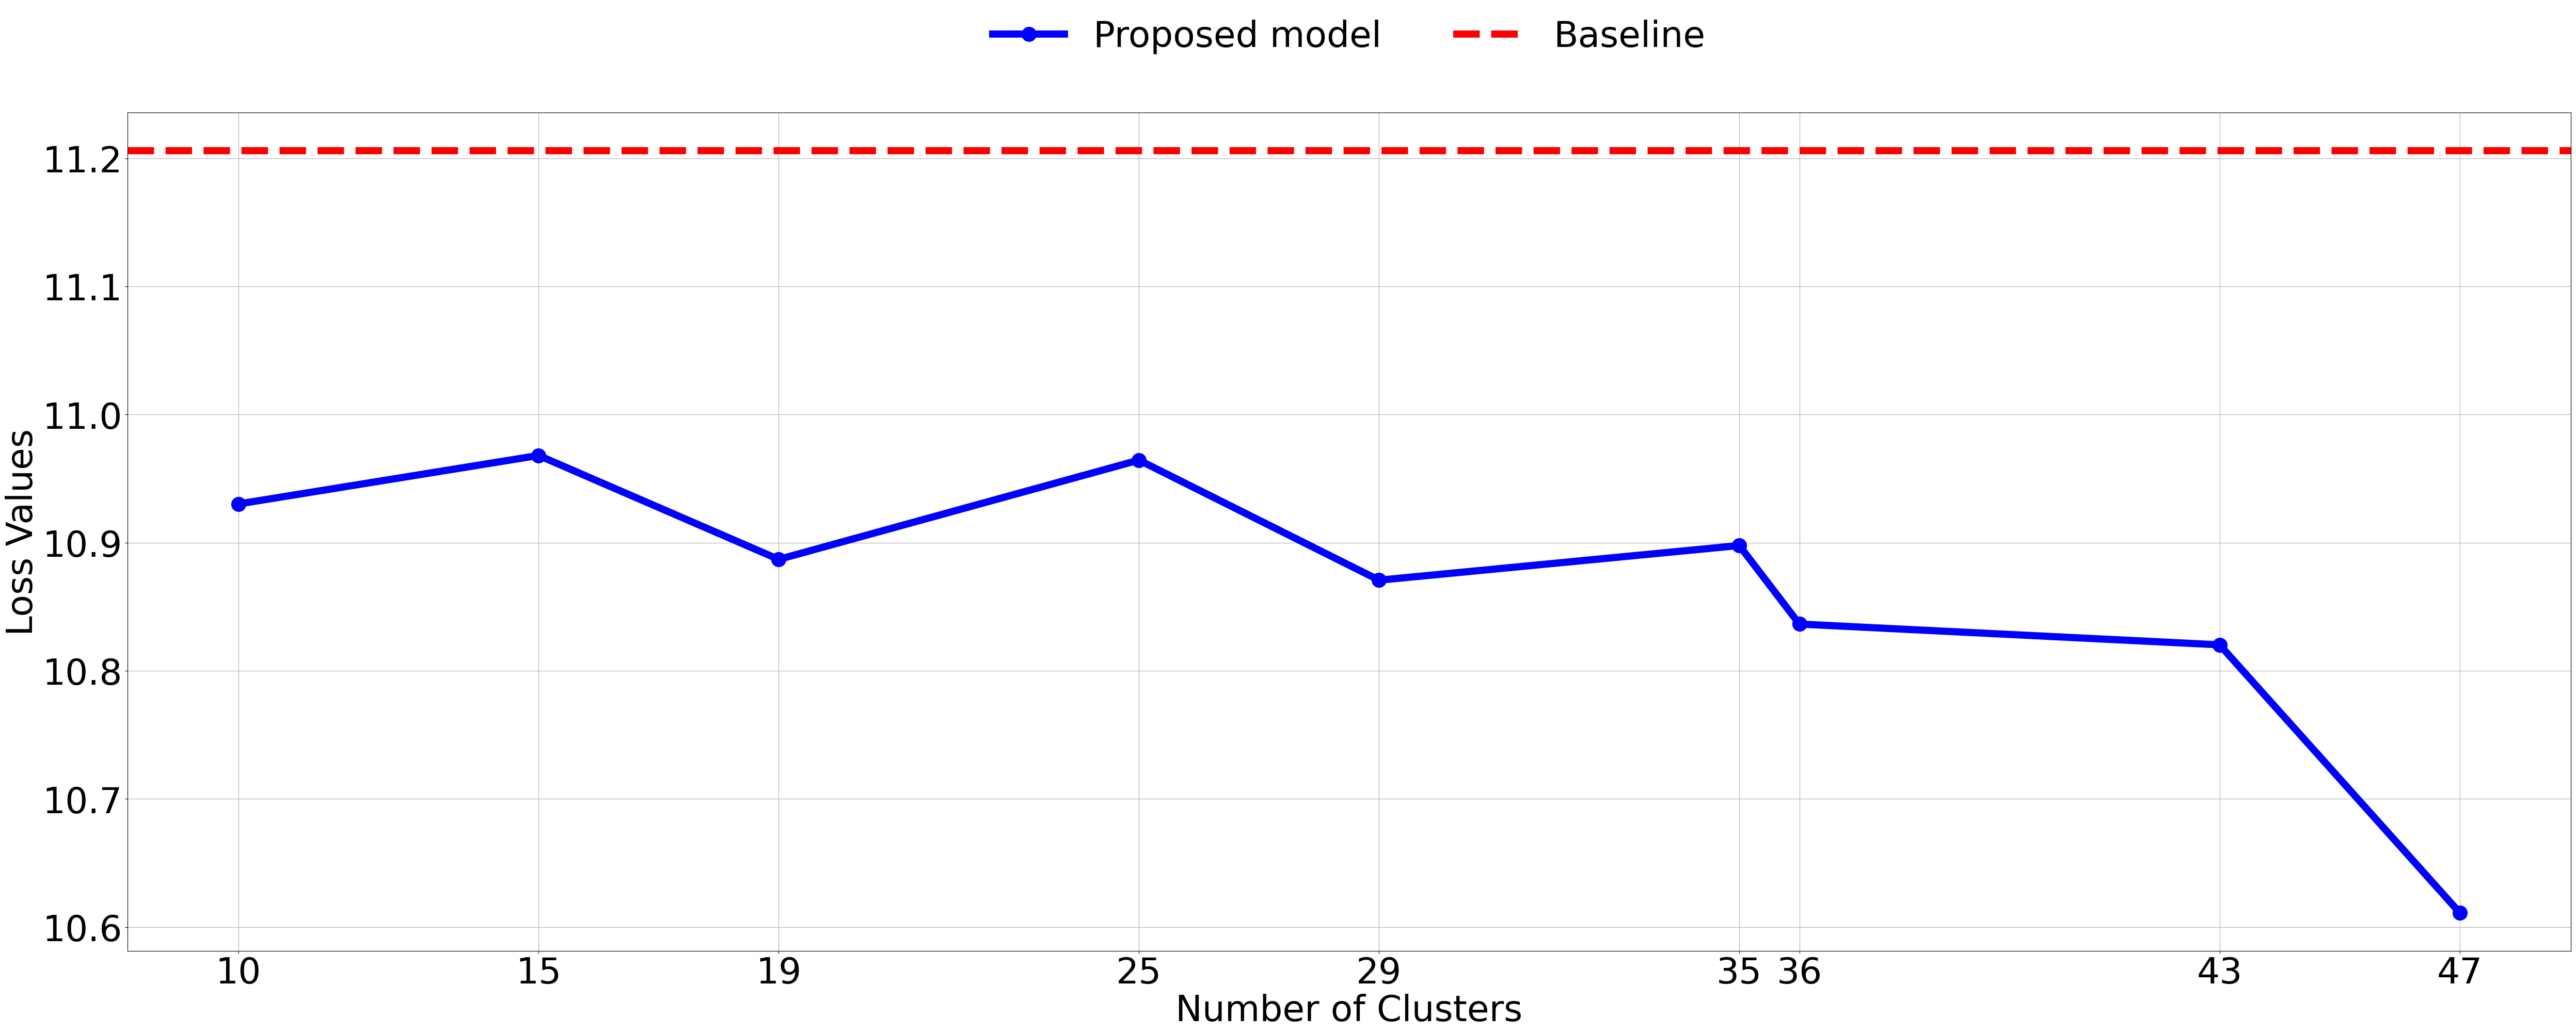

In [7]:
for i in summary_df['round'].unique():
    print(f"Round: {i}")
    round_df = summary_df[summary_df['round'] == i]
    utils.plot_model_performance(round_df, baseline_avg_loss_dict, output_path=None,show_plot=True)

In [8]:
agg_df = summary_df.groupby(['k', 'model', 'n_clusters_set']).agg(
    global_best=('global_best', 'mean'),
    n_cluster=('n_cluster', 'mean')
).reset_index()

# Save the aggregated DataFrame to a CSV file
agg_file_path = os.path.join(Plots_folder, 'global_best_loss_average_summary.csv')
agg_df.to_csv(agg_file_path, index=False)

print(agg_df)

    k model  n_clusters_set  global_best  n_cluster
0  20    DT              10    10.916722        9.8
1  20    DT              15    10.939789       14.9
2  20    DT              20    10.944295       19.8
3  20    DT              25    10.902664       24.3
4  20    DT              30    10.882660       28.5
5  20    DT              35    10.888427       33.9
6  20    DT              40    10.863016       37.8
7  20    DT              45    10.838507       41.9
8  20    DT              50    10.774349       46.7


Plotting for model: DT


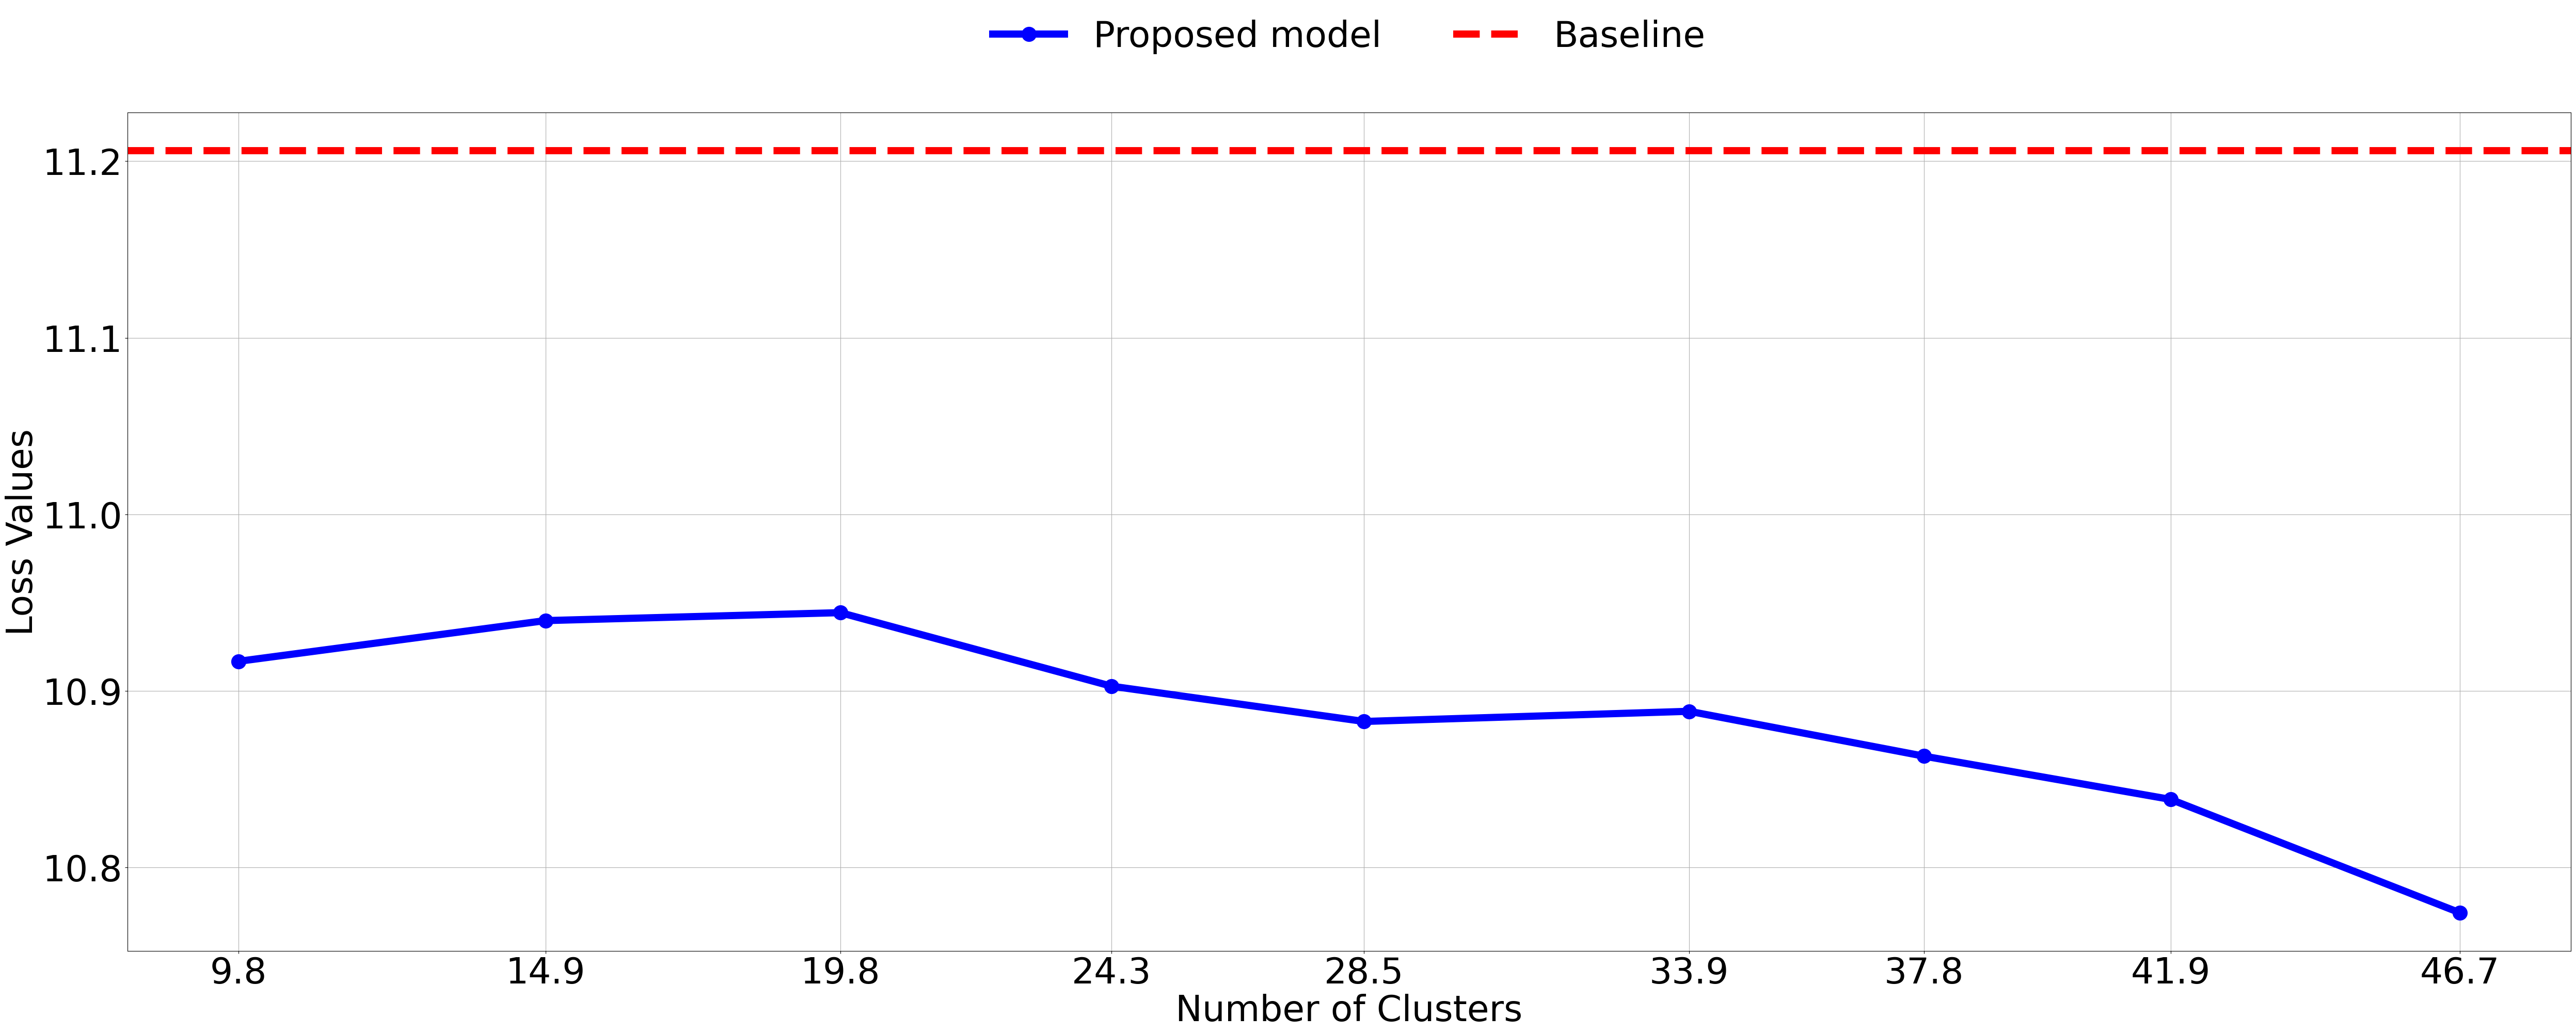

In [9]:
utils.plot_model_performance(agg_df, baseline_avg_loss_dict, output_path=new_plot_path,show_plot=True)

In [10]:
baseline_df = pd.read_excel('/Users/yusiwei/Library/CloudStorage/OneDrive-Personal/research/Fourth Year Paper/Experiments/2nd experiments/Baseline experiment results/German_credit_baseline_ML_results.xlsm', sheet_name='German_credit_baseline_ML_resul')
baseline_df

,Accuracy,Precision,Recall,F1 Score,AUC,Loss,TP,TN,FP,FN,ML_Model
0,0.705,0.786207,0.802817,0.794425,0.634167,10.632878,114,27,31,28,DT
1,0.645,0.750000,0.744681,0.747331,0.575730,12.795497,105,24,35,36,DT
2,0.680,0.776923,0.742647,0.759398,0.644761,11.533969,101,35,29,35,DT
3,0.690,0.789474,0.755396,0.772059,0.648190,11.173533,105,33,28,34,DT
4,0.655,0.772727,0.723404,0.747253,0.607465,12.435060,102,29,30,39,DT
...,...,...,...,...,...,...,...,...,...,...,...
595,0.775,0.816993,0.880282,0.847458,0.818237,0.577997,125,30,28,17,SVM
596,0.765,0.790419,0.916667,0.848875,0.809772,0.582279,132,21,35,12,SVM
597,0.745,0.782609,0.887324,0.831683,0.805367,0.620330,126,23,35,16,SVM
598,0.730,0.759740,0.873134,0.812500,0.779964,0.656751,117,29,37,17,SVM


In [14]:
results_list = []

for file in all_files:
    info = utils.extract_info_from_filename(file, pattern)
    print(f"k: {info['k']}, n_cluster: {info['n_cluster']}, ML model: {info['model']}, Round: {info['round']}")

    # Load the CSV file
    file_path = os.path.join(folder_path, file)
    results_df = pd.read_csv(file_path)

    # Get global best loss values
    loss_values = utils.get_metric_values_of_global_best_particle(results_df, 'Entropy-Loss', agg_func='mean')
    mean_global_best = np.mean(loss_values)
    # Print results
    print(f"Mean Loss - Proposed moddel: {mean_global_best:.4f}")

    # Get baseline loss
    baseline_loss = np.array(baseline_df.loc[baseline_df['ML_Model'] == info['model'], 'Loss'])
    mean_baseline = np.mean(baseline_loss)
    print(f"Mean Loss - Baseline: {mean_baseline:.4f}")

    # Check normality
    differences = loss_values - baseline_loss
    stat, p = shapiro(differences)

    if p > 0.05:
        print("✅ Differences are normally distributed. Proceed with paired t-test.")
        t_stat, p_val = ttest_rel(loss_values, baseline_loss)
        # print(f"t-statistic: p-value: {p_val}")
        if p_val < 0.05:
            print("❌ Reject the null hypothesis: The means are significantly different.")
        else:
            print("✅ Fail to reject the null hypothesis: The means are not significantly different.")
    else:
        print("❌ Differences are NOT normally distributed. Use Wilcoxon signed-rank test.")
        t_stat, p_val = wilcoxon(loss_values, baseline_loss)
        # print(f"Wilcoxon-statistic: p-value: {p_val}")
        if p_val < 0.05:
            print("❌ Reject the null hypothesis: The means are significantly different.")
        else:
            print("✅ Fail to reject the null hypothesis: The means are not significantly different.")
    print("\n")

    # Save the results to a data frame
    results_list.append({
        'Model': info['model'],
        'k': info['k'],
        'n_cluster': info['n_cluster'],
        'Mean Loss - Proposed model': mean_global_best,
        'Mean Loss - Baseline': mean_baseline,
        'p-value': p_val
    })
    


k: 20, n_cluster: 25, ML model: DT, Round: 4
Mean Loss - Proposed moddel: 10.9591
Mean Loss - Baseline: 11.2060
✅ Differences are normally distributed. Proceed with paired t-test.
✅ Fail to reject the null hypothesis: The means are not significantly different.


k: 20, n_cluster: 35, ML model: DT, Round: 0
Mean Loss - Proposed moddel: 10.8690
Mean Loss - Baseline: 11.2060
✅ Differences are normally distributed. Proceed with paired t-test.
❌ Reject the null hypothesis: The means are significantly different.


k: 20, n_cluster: 50, ML model: DT, Round: 8
Mean Loss - Proposed moddel: 10.8582
Mean Loss - Baseline: 11.2060
✅ Differences are normally distributed. Proceed with paired t-test.
❌ Reject the null hypothesis: The means are significantly different.


k: 20, n_cluster: 45, ML model: DT, Round: 3
Mean Loss - Proposed moddel: 10.8149
Mean Loss - Baseline: 11.2060
✅ Differences are normally distributed. Proceed with paired t-test.
❌ Reject the null hypothesis: The means are significant

In [ ]:
summary_stats_df = pd.DataFrame(results_list)

summary_stats_df.to_csv(os.path.join(Plots_folder, 'summary_stats.csv'), index=False)